# DaKanjiRecognizer - Single Kanji CNN : Create dataset

## Setup

Import the needed libraries.

In [2]:
#std lib
import sys
import os
import random
import math
import multiprocessing as mp
import gc
import time
import datetime
from typing import Tuple, List

from tqdm import tqdm
import tensorflow as tf

#reading the dataset
from etldr.etl_data_reader import ETLDataReader
from etldr.etl_character_groups import ETLCharacterGroups
from etldr.etl_data_names import ETLDataNames

from DataGenerator import generate_images, check_font_char_support

#data handling
import PIL
from PIL import Image as PImage
from PIL import ImageFilter, ImageFont, ImageDraw
import numpy as np
import cv2

#plotting/showing graphics
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image

#define a font to show japanese characters in matplotlib figures
import matplotlib.font_manager as fm
show_sample_font = fm.FontProperties(fname=os.path.join("..", "fonts", "NotoSerifCJKjp-Regular.otf"), size=20)

## Loading the data

The [ETL Character data set](http://etlcdb.db.aist.go.jp/) which I am using is a data set with multiple sub sets (ETL1 - ETL7, ETL8B, ETL8G, ETL9B and ETL9G). <br/>
After unpacking the data set I renamed all folders and files to have a uniform naming scheme: "ETLX/ETLX_Y". "X" is the number of the subset and Y the part of the subset. Also ETL7S was removed (ETL7L just smaller), the following renaming was also done: <br/>
ETL8B $\rightarrow$ ETL1, ETL8G $\rightarrow$ ETL9, ETL9B $\rightarrow$ ETL10 and ETL9G $\rightarrow$ ETL11.<br/>
This leads to the following data set structure: <br/> 

| name  |   type  |                    content                                              |   res   | Bit depth |    code    | samples perlabel | total samples |
|:-----:|:-------:|:-----------------------------------------------------------------------:|:-------:|:---------:|:----------:|:----------------:|:-------------:|
| ETL1  | M-Type  | Numbers <br/> Roman <br/> Symbols <br/> Katakana                        |  64x63  |     4     | JIS X 0201 |   ~1400          |     141319    |
| ETL2  | K-Type  | Hiragana <br/> Katakana <br/> Kanji <br/> Roman <br/> Symbols           |  60x60  |     6     |    CO59    |     ~24          |      52796    |
| ETL3  | C-Type  | Numeric <br/> Capital Roman <br/> Symbols                               |  72x76  |     4     | JIS X 0201 |     200          |       9600    |
| ETL4  | C-Type  | Hiragana                                                                |  72x76  |     4     | JIS X 0201 |     120          |       6120    |
| ETL5  | C-Type  | Katakana                                                                |  72x76  |     4     | JIS X 0201 |    ~200          |      10608    |
| ETL6  | M-Type  | Katakana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |    1383          |     157662    |
| ETL7  | M-Type  | Hiragana <br/> Symbols                                                  |  64x63  |     4     | JIS X 0201 |     160          |      16800    |
| ETL8  | 8B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     157662    |
| ETL9  | 8G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |
| ETL10 | 9B-Type | Hiragana <br/> Kanji                                                    |  64x63  |     1     | JIS X 0208 |     160          |     152960    |
| ETL11 | 9G-Type | Hiragana <br/> Kanji                                                    | 128x127 |     4     | JIS X 0208 |     200          |     607200    |


Because the provided data set is distributed in a proprietary binary data format and therefore hard to handle I created a ```ETL_data_reader```-package. This package can be found [here](https://github.com/CaptainDario/ETLCDB_data_reader).
The specific dataformat is C-struct like for types: M, 8B, 8G, 9B, 9G. But the types C and K are 6-bit encoded. All codes can be found on the [official website.](http://etlcdb.db.aist.go.jp/file-formats-and-sample-unpacking-code)
I used the [struct module](https://docs.python.org/3/library/struct.html) and the [bitstring module](https://pypi.org/project/bitstring/) to unpack the binary data. <br/>

First an instance of the ```ERL_data_reader``` -class is needed.
The path parameter should lead to the folder in which all parts of the ETL data set can be found.

In [2]:
path = "Z:\data_sets\ETL_kanji"
reader = ETLDataReader(path)

Define a convenience function for showing characters and their label.

In [3]:
def show_image(img : np.array, label : str):
    plt.figure(figsize=(2.2, 2.2))
    plt.title(label=label, font=show_sample_font)
    plt.axis("off")
    plt.imshow(img.astype(np.float64), cmap="gray")

Now load all samples which contain Kanji, Hiragana and Katakana.

In [13]:
types = [ETLCharacterGroups.kanji, ETLCharacterGroups.katakana, ETLCharacterGroups.hiragana]
x, y = reader.read_dataset_whole(types, 16)
print(x.shape, y.shape)

  0%|          | 0/127 [00:00<?, ?it/s]

(1745185, 64, 64, 1) (1745185,)


With the loaded data we can take a look at the class distributions.

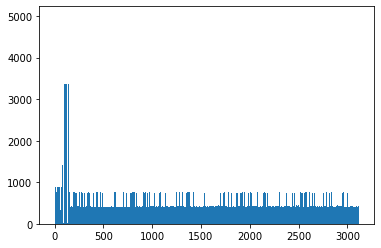

In [14]:
unique, counts = np.unique(y, return_counts=True)
balance = dict(zip(unique, counts))

plt.bar(range(0, len(counts)), counts, width=1.0)
plt.show()

Because the data is quite imbalanced a function to generate artifical data is needed.
If all images are the same, the artifical data is not really useful. <br/>
Therefore a function to augment the created data is also needed. <br/>
This was implemented in `DataGenerator.py` because Multiprocessing and Jupyter do not work nicely together on windows.

Let's create augmented data so that all classes have atleast 1000 samples. <br/>
Therefore a directory of fonts is needed.

In [15]:
# the desired number of samples
num_samples = 500

# read the fonts from file and create ImageFont objects
fonts = [os.path.join(os.path.dirname(os.getcwd()), "fonts", i) for i in os.listdir(os.path.join("..", "fonts"))]

Now we should check that every font supports the characters we want to generate.

In [16]:
arguments = [[fonts, i] for i in unique]

# if the supporting fonts were not saved to file
if(not os.path.isfile("supported_fonts_1.txt")):
    # check which fonts support which character
    if(__name__ == "__main__"):
        with mp.Pool(processes=16) as pool:
            return_values = pool.starmap(check_font_char_support, tqdm(arguments, total=len(arguments)))
    # save the characters and their supported fonts to file
    with open("supported_fonts_1.txt", mode="w+", encoding="utf-8") as f:
        f.write(str(return_values))
# if the supporting fonts were saved to file
else:
    with open("supported_fonts_1.txt", mode="r", encoding="utf-8") as f:
        content = f.read()
        return_values = eval(content)

Now generate the artificial data (with multiple processes).

In [17]:
# create the arguments for each process to balance the data set
slices, cnt = 128, 0
arguments = [[[], [], []] for i in range(slices)]
for key, value in balance.items():
    # if there are less than desired samples
    if(value < num_samples):
        to_generate = num_samples - value
        arguments[cnt % slices][0].append(to_generate)
        arguments[cnt % slices][1].append(key)
        arguments[cnt % slices][2].append(return_values[cnt][1])
        cnt += 1

In [18]:
if(__name__ == "__main__"):
    with mp.Pool(processes=16) as pool:
        return_values = pool.starmap(generate_images, tqdm(arguments, total=len(arguments)))

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [01:59<00:00,  1.07it/s]


Merge the generated data to two big umpy arrays.

In [19]:
augmented_imgs, augmented_labels = [x], [y]

for _imgs, _labels in return_values: 
    if(len(_imgs) > 0 and len(_labels) > 0):
        augmented_imgs.append(_imgs)
        augmented_labels.append(_labels)

x = np.concatenate(augmented_imgs)
augmented_imgs = None
y = np.concatenate(augmented_labels)
augmented_labels = None
gc.collect()

183889

When taking a look at the new class distribution it should be nearly balanced.

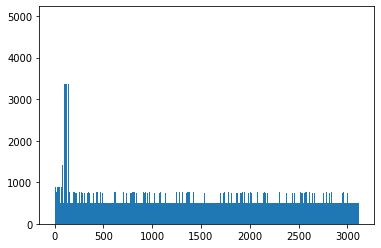

In [20]:
unique, counts = np.unique(y, return_counts=True)
balance = dict(zip(unique, counts))

plt.bar(range(0, len(counts)), counts, width=1.0)
plt.show()

### Save (augmented) images to disk 
To use the data later with keras we save them to disk in an appropriate folder structure. <br/>
The ETL_data_reader package provides a handy function for this.

In [21]:
reader.save_to_file(x, y, r"Z:\data_sets\etlcdb", name=0)

  0%|          | 0/1944553 [00:00<?, ?it/s]

## Create images for missing JIS-2 Kanji

Because not all JIS 2 characters are in the etlcdb we need to create artifical samples for them. <br/>
First find the characters which are in JIS2 but not in the data set.

In [22]:
jis = ""
with open("jis2_characters.txt", encoding="utf-8") as f:
    jis = f.read()

jis = jis.replace("\n", " ").split(" ")

needed_characters = [c for c in jis if c not in unique]

Now find all fonts which support the given character.

In [23]:
arguments = [[fonts, i] for i in needed_characters]

# if the supporting fonts were not saved to file
if(not os.path.isfile("supported_fonts_2.txt")):
    # check which fonts support which character
    if(__name__ == "__main__"):
        with mp.Pool(processes=16) as pool:
            return_values = pool.starmap(check_font_char_support, tqdm(arguments, total=len(arguments)))
    # save the characters and their supported fonts to file
    with open("supported_fonts_2.txt", mode="w+", encoding="utf-8") as f:
        f.write(str(return_values))
# if the supporting fonts were saved to file
else:
    with open("supported_fonts_2.txt", mode="r", encoding="utf-8") as f:
        content = f.read()
        return_values = eval(content)

100%|██████████████████████████████████████████████████████████████████████████████| 3388/3388 [13:26<00:00,  4.20it/s]


Now generate the artificial data in parallel.

In [24]:
# how many different characters were already in the etlcdb
etlcdb_num_samples = len(unique)
print(etlcdb_num_samples)

# free memory
x, y, augmented_x, augmented_y = None, None, None, None
gc.collect()

# create the arguments for each process to generate jis2 kanji
slices, cnt = 128, 0
arguments = [[[], [], []] for i in range(slices)]
for c in needed_characters:
    arguments[cnt % slices][0].append(num_samples)
    arguments[cnt % slices][1].append(c)
    arguments[cnt % slices][2].append(return_values[cnt][1])
    cnt += 1

3119


In [25]:
if(__name__ == "__main__"):
    with mp.Pool(processes=16) as pool:
        return_values = pool.starmap(generate_images, tqdm(arguments, total=len(arguments)))

100%|████████████████████████████████████████████████████████████████████████████████| 128/128 [03:07<00:00,  1.47s/it]


Finally merge the data into two arrays.

In [26]:
augmented_imgs, augmented_labels = [], []

for _imgs, _labels in return_values: 
    if(len(_imgs) > 0 and len(_labels) > 0):
        augmented_imgs.append(_imgs)
        augmented_labels.append(_labels)

x = np.concatenate(augmented_imgs)
augmented_imgs = None
y = np.concatenate(augmented_labels)
augmented_labels = None
gc.collect()

65

### Save (augmented) images to disk 
To use the data later with keras we save them to disk in an appropriate folder structure.
The ETL_data_reader package provides a handy function for this.

In [27]:
reader.save_to_file(x, y, r"Z:\data_sets\etlcdb", name=etlcdb_num_samples)

  0%|          | 0/1694000 [00:00<?, ?it/s]